## El mundo del Wumpus (2/2)

Adaptado de Russell & Norvig (2016), cap. 7.

### Objetivo

En este notebook completaremos la arquitectura necesaria para construir el programa de agente que permita superar el reto de encontrar el oro en la cueva del Wumpus (sin morir en el intento).

### Secciones

Desarrollaremos la explicación de la siguiente manera:

1. Encontrar casillas seguras para transitar.
* Diseñar un plan para ir de la casilla actual a una casilla objetivo.
* Toma de decisiones y planeación para superar el mundo del Wumpus.

### Recorderis

Todo el código relevante del anterior notebook se puede importar del paquete Wumpus:

In [1]:
from Wumpus import *
%matplotlib notebook

La siguiente tabla puede ser útil para futuras referencias y puede irse completando a medida que se vaya avanzando en la representación:

| Información | Número de codificación |
| :---: | :---: |
| Casilla segura     | 0    |
| Casilla con brisa     | 1 |
| Casilla con pozo     | 2 |
| Casilla con hedor     | 3 |
| Casilla con Wumpus vivo    | 4 |

Se inicializan los objetos necesarios:

In [2]:
# Se crea objeto de codificación
cods = codigos(4, 4, 5)
# Se crean las formulas de representación del mundo
lista_formulas = formulas_brisa(cods, 4) 
lista_formulas += formulas_hedor(cods)
lista_formulas += formulas_segura(cods)
# Se inicializa la base de conocimiento
Base_wumpus = lp_query(lista_formulas, cods)
# Base_wumpus.visualizar()
# Se inicializa el mundo
W = wumpus()
# Se percibe la casilla inicial
percibir(W)

[None, 'brisa', None, None, None]

Recuerde que los sensores del agente devuelven información así:

[hedor, brisa, brillo, batacazo, grito]

## Encontrando casillas seguras para transitar

Con base en la información sensorial, pregúntese a sí mismo: "Mí mismo, ¿qué casillas creo que son seguras?"

El agente puede responder a esta pregunta usando la función `ASK` sobre la casilla presente y las adyacentes. Pero es necesario incluir la información perceptual en la base de conocimiento para poder hacer las inferencias correctas. Para ello, creamos la función `make_percept_sentence`, la cual crea los literales que se van a incluir en la base de conocimiento:

In [3]:
def make_percept_sentence(percept, indice, cods):
    # Crea una conjuncion de literales para añadir a la base de datos
    
    literales = ''
    x, y = indice
    if percept[0] != None:
        literales += cods.P(x, y, 3)
    else:
        literales += '-' + cods.P(x, y, 3)
    if percept[1] != None:
        literales += 'Y' + cods.P(x, y, 1)
    else:
        literales += 'Y-' + cods.P(x, y, 1)
    return literales

In [4]:
datos = make_percept_sentence(percibir(W), W.heroe, cods)
TELL(Base_wumpus, datos)
# Base_wumpus.visualizar()

Preguntamos ahora a la base de conocimiento cuáles de las casillas adyacentes y la actual son seguras:

In [5]:
for casilla in [W.heroe] + adyacentes(W.heroe):
    x, y = casilla
    objetivo = cods.P(x, y, 0)
    print("Casilla", casilla, "es segura?", ASK(objetivo, True, Base_wumpus))

Casilla (0, 0) es segura? False
Casilla (1, 0) es segura? False
Casilla (0, 1) es segura? False


**Ejercicio 1:**

Observe que el agente no cree que la casilla inicial es segura. Complete la función `make_percept_sentence` para incluir los literales que afirman que en la casilla actual no hay un pozo ni está el Wumpus vivo (si los hubiera, el agente estaría muerto).

**Respuesta:**

Una posible implementación es la siguiente:

In [6]:
def make_percept_sentence(percept, indice, cods):
    # Crea una conjuncion de literales para añadir a la base de datos
    
    literales = ''
    x, y = indice
    if percept[0] != None:
        literales += cods.P(x, y, 3)
    else:
        literales += '-' + cods.P(x, y, 3)
    if percept[1] != None:
        literales += 'Y' + cods.P(x, y, 1)
    else:
        literales += 'Y-' + cods.P(x, y, 1)
    literales += 'Y-' + cods.P(x, y, 2)
    literales += 'Y-' + cods.P(x, y, 4)
    return literales

---

Volvemos a determinar qué casillas son seguras desde el punto de vista del agente. Esta vez, guardamos estos datos en la base de conocimiento:

In [7]:
datos = make_percept_sentence(percibir(W), W.heroe, cods)
TELL(Base_wumpus, datos)
for casilla in [W.heroe] + adyacentes(W.heroe):
    x, y = casilla
    objetivo = cods.P(x, y, 0)
    if ASK(objetivo, True, Base_wumpus):
        print("Casilla", casilla, "es segura!")
        TELL(Base_wumpus, cods.P(x, y, 0))
    else:
        print("Casilla", casilla, "NO es segura!")
        
Base_wumpus.visualizar('datos')  # Opciones de visualizar: 'todo', 'datos', 'reglas'

Casilla (0, 0) es segura!
Casilla (1, 0) NO es segura!
Casilla (0, 1) NO es segura!
Datos:
-Hedor(0, 0)
Brisa(0, 0)
-Pozo(0, 0)
-Wumpus(0, 0)
Segura(0, 0)


### Planeación de rutas

Si ninguna de las casillas adyacentes es segura, el agente está en un aprieto. Puede elegir entre salir de la cueva (y olvidarse del oro) o dar un paso en la oscuridad (y atenerse a las consecuencias!). 

Antes de considerar el proceso de toma de decisiones, pensemos en que se requiere un plan para moverse desde la casilla actual hasta una casilla objetivo. Poder diseñar estos planes le servirá al agente cuando necesite avanzar a casillas adyacentes, devolverse a la casilla inicial y salir de la cueva, etc.

Planear una ruta desde la casilla actual hasta una casilla objetivo a la cual se desea ir es un problema muy similar a los que ya hemos encontrado en sesiones pasadas. Debemos definir un problema `rejilla` y luego usar un algoritmo de búsqueda sobre este.

**Importante:** En este punto estamos considerando que la planeación de una ruta consiste en determinar qué casillas debe transitar el agente. Más adelante volveremos sobre el problema de convertir una lista de casillas en la correspondiente lista de acciones que el agente debe ejecutar.

**Ejercicio 2:**

Implemente un código python para definir el problema `rejilla`, el cual debe tener un atributo `estado_inicial` con la información de la posición del agente, un atributo `estado_objetivo` (el cual se inicializa con la casilla inicial), y un atributo `casillas_seguras` con la información de cuáles casillas el agente cree que son seguras. También debe incluir los métodos `acciones_aplicables` (moverse a una casilla adyacente que se cree que es segura), `transicion`, `test_objetivo` y `costo` (donde el costo de cada movimiento es 1).

**Respuesta:**

Una posible implementación es la siguiente:

In [11]:
class rejilla:
    
    # Problema del tránsito por la rejilla
    # desde donde está el héroe hasta una
    # casilla objetivo
    
    def __init__(self, actual, objetivo, seguras):
        self.estado_inicial = actual
        self.estado_objetivo = objetivo
        self.casillas_seguras = seguras
    
    def acciones_aplicables(self, estado):
        return [casilla for casilla in adyacentes(estado) if casilla in self.casillas_seguras]
    
    def transicion(self, estado, accion):
        return accion
       
    def test_objetivo(self, estado):
        return estado == self.estado_objetivo
    
    def costo(self, estado, accion):
        return 1

In [12]:
seguras = [(x, y) for x in range(4) for y in range(4)] # Supongamos que todas las casillas son seguras
R = rejilla(W.heroe, (3,2) , seguras)
print("Estado inicial:", R.estado_inicial)
print("Estado objetivo:", R.estado_objetivo)

Estado inicial: (0, 0)
Estado objetivo: (3, 2)


---

**Ejercicio 3:**

Una manera muy eficiente de buscar una ruta desde la casilla inicial hasta la casilla objetivo es mediante una función heurística $f$ que resulta de sumar el costo del nodo $g$ con la distancia Manhattan $h$ entre la casilla inicial y la casilla objetivo. En general, a la búsqueda que ordena los nodos en la frontera de acuerdo a esta suma se le conoce como $A^*$-search. Implemente un código python para el algoritmo $A^*$-search.

**Respuesta:**

Una posible implementación es la siguiente:

In [13]:
def f(n, indice):
    # Distancia Manhattan
    # Input: n, nodo de la rejilla
    #        indice, casilla como pareja de enteros (x,y)
    x1, y1 = n.estado
    x2, y2 = indice
    return abs(x1 - x2) + abs(y1 - y2) + n.costo

def nodo_en_frontera(n, objetivo, frontera):
    if f(n, objetivo) not in frontera.keys():
        return False
    elif n not in frontera[f(n, objetivo)]:
        return False
    else:
        return True

In [14]:
def A_star_search(problema):
    
    raiz = nodo(problema.estado_inicial, None, None, 0)    
    objetivo = problema.estado_objetivo
    frontera = {f(raiz, objetivo): [raiz]}
    explored = []
    
    while (len(frontera) > 0):
        n = choice(frontera[min(frontera.keys())]) 
        frontera[f(n, objetivo)].remove(n)
        if len(frontera[f(n, objetivo)]) == 0:
            del frontera[f(n, objetivo)]
        explored.append(n.estado)
        acciones = problema.acciones_aplicables(n.estado)
        for a in acciones:
            N = nodo_hijo(problema, n, a)
            if problema.test_objetivo(N.estado):
                return N
            elif (N.estado not in explored) and not nodo_en_frontera(N, objetivo, frontera):                
                try:
                    frontera[f(N, objetivo)].append(N)
                except:
                    frontera[f(N, objetivo)] = [N]
    
    return None

Verifique su código planeando una ruta desde la casilla incial a la casilla (3, 2), asumiendo que todas las casillas son seguras.

In [15]:
seguras = [(x, y) for x in range(4) for y in range(4)]
R = rejilla((0,0), (3,2) , seguras)
camino = A_star_search(R)
camino = solucion(camino)
camino

[(1, 0), (1, 1), (2, 1), (2, 2), (3, 2)]

---

El siguiente es un sencillo código para transformar la lista de casillas en una lista de acciones que puede ejecutar el agente para transitar las casillas:

In [16]:
def voltear(direccion_inicial, direccion_final):
    acciones = []
    if direccion_inicial == direccion_final:
        return acciones
    else:
        if direccion_final == 'este':
            if direccion_inicial == 'norte':
                acciones.append('voltearDerecha')
            elif direccion_inicial == 'sur':
                acciones.append('voltearIzquierda')
            elif direccion_inicial == 'oeste':
                acciones.append('voltearDerecha')
                acciones.append('voltearDerecha')
        elif direccion_final == 'norte':
            if direccion_inicial == 'este':
                acciones.append('voltearIzquierda')
            elif direccion_inicial == 'sur':
                acciones.append('voltearIzquierda')
                acciones.append('voltearIzquierda')
            elif direccion_inicial == 'oeste':
                acciones.append('voltearDerecha')
        elif direccion_final == 'oeste':
            if direccion_inicial == 'este':
                acciones.append('voltearIzquierda')
                acciones.append('voltearIzquierda')
            elif direccion_inicial == 'sur':
                acciones.append('voltearDerecha')
            elif direccion_inicial == 'norte':
                acciones.append('voltearIzquierda')
        elif direccion_final == 'sur':
            if direccion_inicial == 'este':
                acciones.append('voltearDerecha')
            elif direccion_inicial == 'norte':
                acciones.append('voltearDerecha')
                acciones.append('voltearDerecha')
            elif direccion_inicial == 'oeste':
                acciones.append('voltearIzquierda')
    return acciones

def acciones_camino(camino, direccion):
    acciones = []
    for i in range(len(camino) - 1):
        x1, y1 = camino[i]
        x2, y2 = camino[i + 1]
        diferencia_x = x2 - x1
        diferencia_y = y2 - y1
        if (diferencia_x != 0) and (diferencia_y != 0):
            print("Camino incorrecto!: No debe incluir diagonales.")
            return None
        elif diferencia_x > 0:            
            acciones += voltear(direccion, 'este')
            direccion = 'este'
        elif diferencia_x < 0:
            acciones += voltear(direccion, 'oeste')
            direccion = 'oeste'
        elif diferencia_y > 0:            
            acciones += voltear(direccion, 'norte')
            direccion = 'norte'
        elif diferencia_y < 0:
            acciones += voltear(direccion, 'sur')
            direccion = 'sur'
        acciones.append('adelante')
    return acciones


In [17]:
camino = [(0,0)] + camino
camino

[(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (3, 2)]

In [18]:
acciones = acciones_camino(camino, W.direccion)
print(acciones)

['adelante', 'voltearIzquierda', 'adelante', 'voltearDerecha', 'adelante', 'voltearIzquierda', 'adelante', 'voltearDerecha', 'adelante']


## Toma de decisiones

Una función auxiliar muy útil para obtener la lista de casillas seguras de acuerdo a la información en la base de conocimiento:

In [23]:
def casillas_seguras(base, locacion, cods):
    # Razona para determinar qué casillas son seguras
    for casilla in [locacion] + adyacentes(locacion):
        x, y = casilla
        objetivo = cods.P(x, y, 0)
        if ASK(objetivo, True, Base_wumpus):
            TELL(Base_wumpus, cods.P(x, y, 0))
    # Extrae los literales Seguras de la base de datos
    seguras = []
    for literal in base.base_conocimiento['datos']:
        if len(literal) == 1:
            x, y, z = cods.Pinv(literal)
            if z == 0:
                seguras.append((x,y))
    return seguras

In [27]:
def hybrid_wumpus_agent(percept):
    
    global W
    global Base_wumpus
    global cods
    global rejilla
    global plan
    
    # Determina la locación y direccion actual
    locacion = W.heroe
    direccion = W.direccion
    # Incluye la información de los sensores en la base de datos
    datos = make_percept_sentence(percept, locacion, cods)
    TELL(Base_wumpus, datos)
    # Obtiene las casillas seguras de la base de datos
    seguras = casillas_seguras(Base_wumpus, locacion, cods)
    # Planea moverse a una casilla segura
    if (len(plan) > 0) and (len(seguras) > 1):
        objetivo = choice([casilla for casilla in seguras if casilla!=locacion])
        R = rejilla(locacion, objetivo, seguras)
        camino = A_star_search(R)
        if camino != None:
            camino = solucion(camino)
        else:
            camino = []
        plan = acciones_camino([locacion] + camino, direccion)
    else:
        objetivo = (0,0)
        R = rejilla(locacion, objetivo, seguras)
        camino = A_star_search(R)
        if camino != None:
            camino = solucion(camino)
        else:
            camino = []
        print
        plan = acciones_camino([locacion] + camino, direccion)
        plan += ['salir']
    accion = plan.pop(0)
    return accion        

In [25]:
Base_wumpus = lp_query(lista_formulas, cods)
# Base_wumpus.visualizar()
# Se inicializa el mundo
W = wumpus()
plan = []
print(percibir(W))

[None, 'brisa', None, None, None]


¡Juego terminado!
Puntaje: -1


<IPython.core.display.Javascript object>


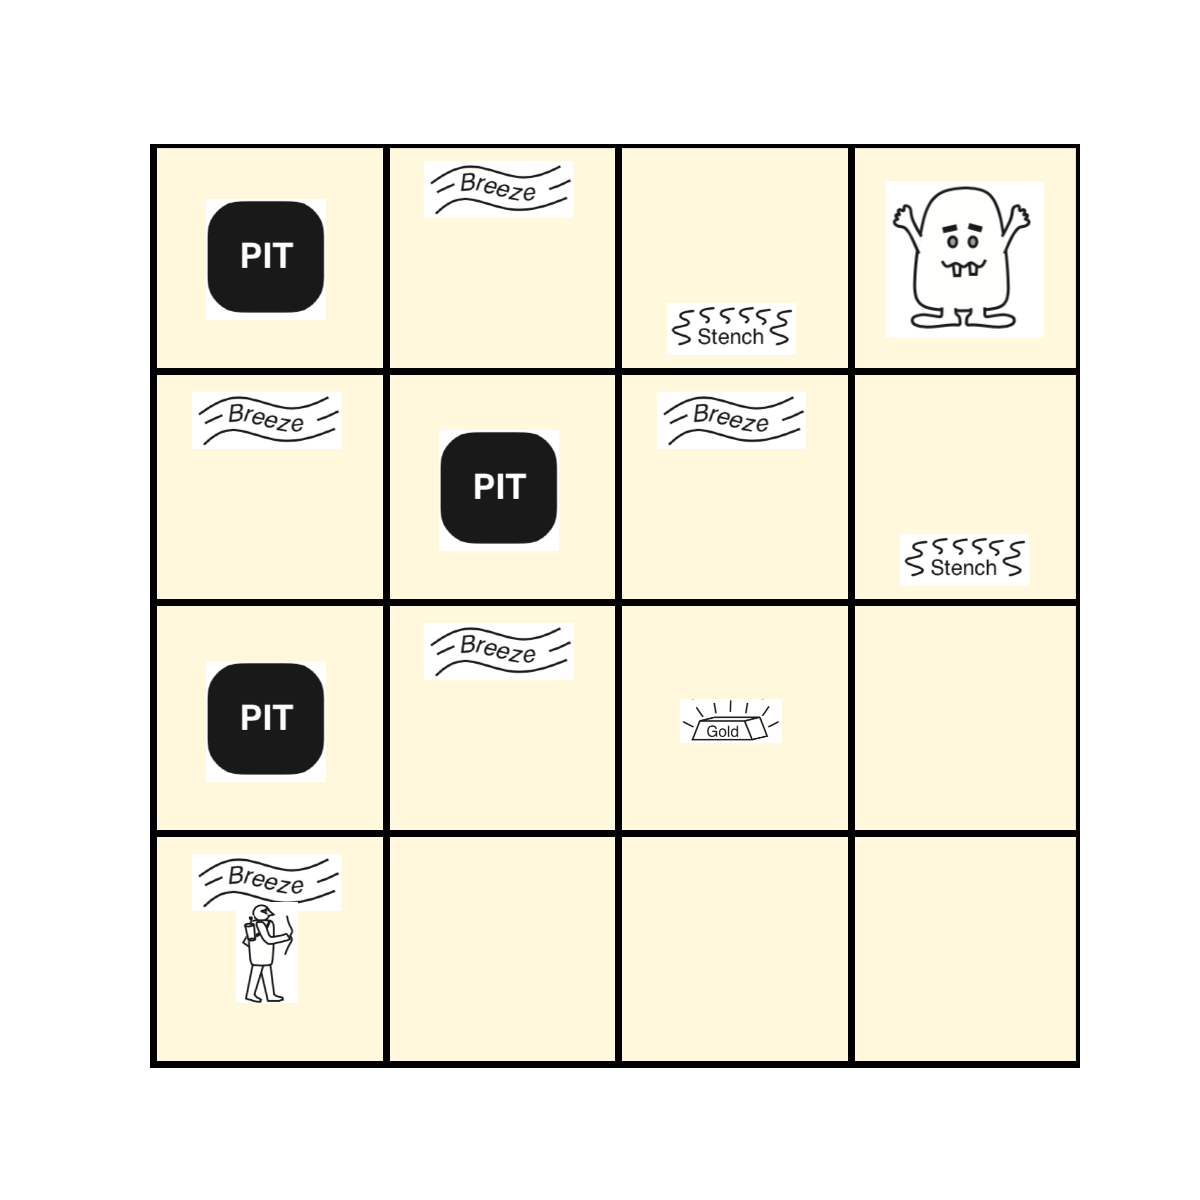

In [28]:
while W.juego_activo:
    percept = percibir(W)
    accion = hybrid_wumpus_agent(percept)
    W.transicion(accion)
    W.pintar_casilla()

<img src="./imagenes/hybrid-wumpus-agent.png" width="350">

**Ejercicio 3:**

Use una lista como la variable *frontera* e implemente la función `tree_search` para resolver el problema de las ocho damas.

***Importante:*** Limíte la cantidad de hijos generados por un nodo a sólo 3.

**Respuesta:**

Una posible implementación es la siguiente:

---

In [ ]:
l = A_star_search(R)
if l: 
    print("Solución:", solucion(l))
else:
    print("No hay solución!")

---

**Ejercicio 4:**

Leer en el texto guía la discusión sobre caminos redundantes y el algoritmo `graph_search` (sección 3.3, págs. 76-77).

---

---

### En este notebook usted aprendió

* Cómo definir formalmente un problema e implementarlo en python.

* En qué consiste un árbol de búsqueda y cómo implementarlo en python.

* Cómo realizar una búsqueda mediante los métodos *breadth-first* y *depth-limited* e implementarlos en python.